In [1]:
import csv
import shutil
import numpy as np
from random import shuffle
import glob
import tensorflow as tf
import sys
import cv2
import matplotlib.pyplot as plt

In [5]:
def list_label(path_CSV, file_CSV, path_trainingSet):
    csv_file = path_CSV + file_CSV
    
    shuffle_data= True
    train_data_path = path_trainingSet
    
    addrs = sorted(glob.glob(train_data_path))
    
    try:
        with open(csv_file, "rt") as f:
            reader = csv.DictReader(f)
            labels = [1 if float(row['melanoma'])==1.0 else 0 for row in reader]
                      
    except Exception as e:
            print("Unable to read CSV file")
    
    if shuffle_data:
        c = list(zip(addrs,labels))
        shuffle(c)
        addrs,labels = zip(*c) 
        
    
    return addrs, labels
                    

In [6]:
def load_image(addr):
    img = cv2.imread(addr)
    img = cv2.resize(img, (28, 28), interpolation = cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)
    
    return img

In [7]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list = tf.train.BytesList(value=[value]))
    

In [8]:
def write_TF(path, train_addrs,train_labels):
    train_filename = path
    
    writer = tf.python_io.TFRecordWriter(train_filename)
    
    for i in range(len(train_addrs)):
        print(i,end=' ')
        if not i % 1000:
            print ("Train data: {}/{}".format(i, len(train_addrs)))
            sys.stdout.flush()
    
        img = load_image(train_addrs[i])
        print("Image shape:", end= " ")
        print(img.shape, end = " ")
        img = img.tostring()
        print("Image shape after tostring:", end= " ")
        print(len(img), end = " ")
        img=tf.compat.as_bytes(img)
        label = train_labels[i]

        feature = {'train/label': _int64_feature(label),
                  'train/image':_bytes_feature(img)}

        example = tf.train.Example(features= tf.train.Features(feature = feature))

        writer.write(example.SerializeToString())
        

    writer.close()
    sys.stdout.flush()

In [9]:
def main():
    image_folder_path ="/home/mudit/AI/ISIC-2017_Training_Data/*.jpg"
    csv_file_path = "/home/mudit/AI/"
    csv_file_name = "ISIC-2017_Training_Part3_GroundTruth.csv"
    train_filename_path = "/home/mudit/AI/training.tfrecords"
    
    print("listing label")
    addrs, labels = list_label(csv_file_path, csv_file_name,image_folder_path)
    
    write_TF(train_filename_path,addrs, labels)
    

In [ ]:
main()

In [2]:
def read_TF(tf_path):
    data_path = tf_path  # address to save the hdf5 file

    with tf.Session() as sess:
        feature = {'train/image': tf.FixedLenFeature([], tf.string),
                   'train/label': tf.FixedLenFeature([], tf.int64)}

        # Create a list of filenames and pass it to a queue
        filename_queue = tf.train.string_input_producer([data_path], num_epochs=1)

        # Define a reader and read the next record
        reader = tf.TFRecordReader()
        _, serialized_example = reader.read(filename_queue)

        # Decode the record read by the reader
        features = tf.parse_single_example(serialized_example, features=feature)

        # Convert the image data from string back to the numbers
        image = tf.decode_raw(features['train/image'], tf.uint8)

        # Cast label data into int32
        label = tf.cast(features['train/label'], tf.int64)

        # Reshape image data into the original shape
        image = tf.reshape(image, [224, 224, 3])

        # Any preprocessing here ...

        # Creates batches by randomly shuffling tensors
        images, labels = tf.train.shuffle_batch([image, label], batch_size=10, capacity=30, num_threads=1, min_after_dequeue=10)
        
        init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
        sess.run(init_op)
        # Create a coordinator and run all QueueRunner objects
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        for batch_index in range(5):
            img, lbl = sess.run([images, labels])
            img = img.astype(np.uint8)
            for j in range(6):
                plt.subplot(2, 3, j+1)
                plt.imshow(img[j, ...])
                plt.title('seb' if lbl[j]==0 else 'melanoma')
            plt.show()
        # Stop the threads
        coord.request_stop()

        # Wait for threads to stop
        coord.join(threads)
        sess.close()

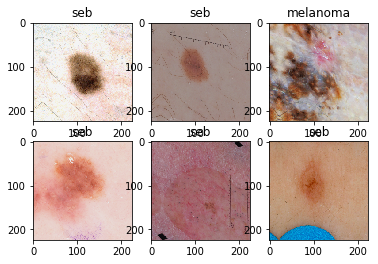

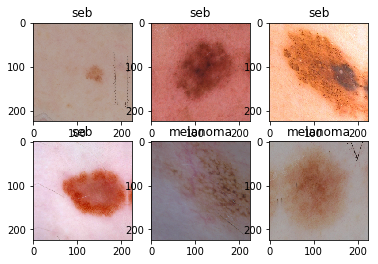

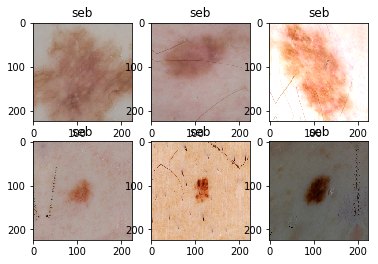

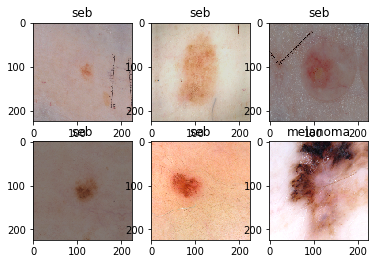

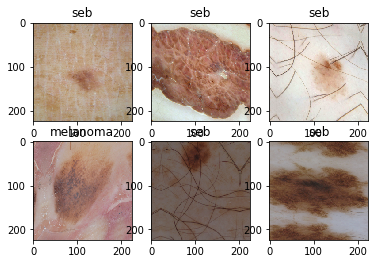

In [3]:
read_TF("/home/mudit/Skin Lesion Classification/TFrecord_Datasets/Melanoma_Training_Augmented_224_uint8.tfrecords")